In [123]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

from collections import Counter

%matplotlib inline

In [39]:
PATH = "."

In [44]:
train = pd.read_csv(f"{PATH}/data.csv")

In [45]:
train.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,509,147,621,254
1,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,444,146,514,258
2,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,345,219,457,328
3,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,287,340,407,445
4,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,1,154,86,245


In [46]:
train['xmin'],train['xmax'] = train['xmin'] / 640,train['xmax'] / 640
train['ymin'],train['ymax'] = train['ymin'] / 480,train['ymax'] / 480

In [47]:
train['h'] = train.ymax - train.ymin
train['w'] = train.xmax - train.xmin

train['y'] = train.ymin + (train.h / 2)
train['x'] = train.xmin + (train.w / 2)

In [48]:
train.head(2)

,filename,width,height,class,xmin,ymin,xmax,ymax,h,w,y,x
0,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,0.795312,0.306250,0.970313,0.529167,0.222917,0.175000,0.417708,0.882812
1,./JPEGImages/BloodImage_00266.jpg,640,480,RBC,0.693750,0.304167,0.803125,0.537500,0.233333,0.109375,0.420833,0.748437


In [49]:
class JSON(object):
    """
    Helper Class For Mapping JSON vars to Objects
    """
    def __init__(self,data=dict(),inner=False):
        for key in data:
            if type(data[key]) == dict:
                self.__dict__[key] = JSON(data[key],inner=True)
            else:
                self.__dict__[key] = data[key]

    def __repr__(self):
        return self.__dict__.__str__()
    
    def __str__(self):
        return self.__dict__.__str__()
    
    def __getitem__(self,key):
        return self.__dict__[key]
    
    def __setitem__(self,key,value):
        self.__dict__[key] = value
    
    def __iter__(self):
        for key in self.__dict__:
            if type(self.__dict__[key]) == JSON:
                yield key, self.__dict__[key]()
            else:
                yield key, self.__dict__[key]
        
    def __call__(self,):
        return {i:j for i,j in  self.__iter__()}

In [345]:
data = []
grouped = train.groupby(by='filename')

for i in train.filename.unique():
    group = grouped.get_group(i)[['class','xmin','ymin','xmax','ymax','x','y','h','w']]
    group = group.T.to_dict().values()
#     [group['class'] != 'RBC']
    boxes = [JSON(i) for i in group]
    if len(boxes):
        data.append(JSON({
            'filename':i,
            'boxes':boxes
        }))

In [346]:
len(data)

364

In [347]:
IMG_SIZE = 448

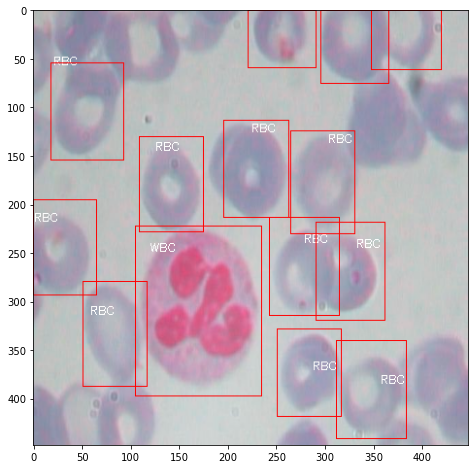

In [348]:
image = data[np.random.randint(len(data))]

img = cv2.imread(image['filename'])
img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))

for box in image['boxes']:
    img = cv2.putText(img,box['class'],(int(box['xmin']*512),int(box['ymin']*512)-5),cv2.FONT_HERSHEY_SIMPLEX,0.4,(255,255,255))
    img = cv2.rectangle(
            img,
            (int(box.xmin*IMG_SIZE),int(box.ymin*IMG_SIZE)),
            (int(box.xmax*IMG_SIZE),int(box.ymax*IMG_SIZE)),
            (255,0,0),
            1
        )

plt.figure(figsize=(12,8))
plt.imshow(img)

In [349]:
images = np.array([cv2.resize(cv2.imread(i['filename']),(IMG_SIZE,IMG_SIZE)) for i in data])

In [350]:
images = images.astype(np.float32) / 255

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


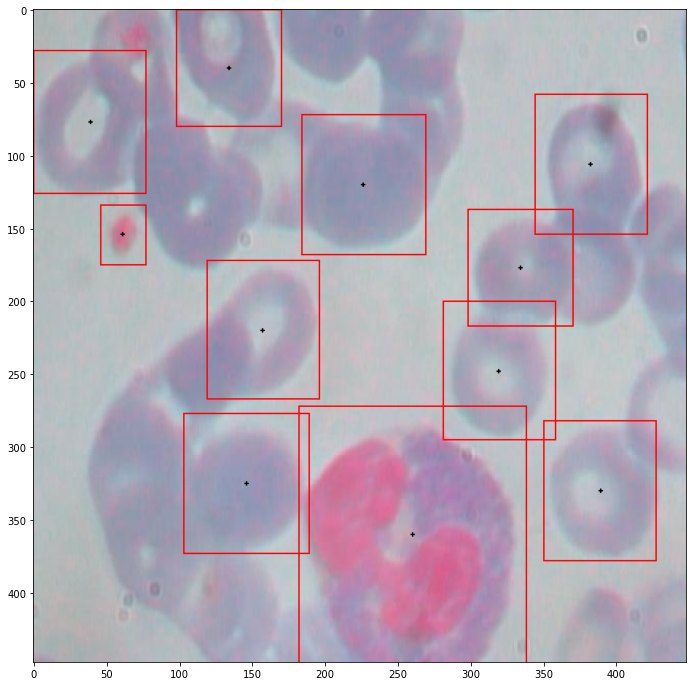

In [351]:
i = np.random.randint(len(images))

img = images[i].copy()
dat = data[i]

for d in dat.boxes:
    img = cv2.rectangle(
                    img,
                    (int(d.xmin*IMG_SIZE),int(d.ymin*IMG_SIZE)),
                    (int(d.xmax*IMG_SIZE),int(d.ymax*IMG_SIZE)),
                    (255,0,0),
                    1
                )
    
    img = cv2.circle(
                    img,
                    (int(d.x*IMG_SIZE),int(d.y*IMG_SIZE)),
                    1,
                    (0,0,0),
                    -1
                )

plt.figure(figsize=(12,12
                   ))
plt.imshow(img)

In [352]:

"""
> Generates n X n grid for anchor refference.

> Resizing image to a fixed square size helps generating more intuitive grid

> Using image size 448x448 and downsampling factor of 64 wil give 7x7 grid.
 
> Box sizes are used for creating refference anchor boxes, there are three sizes
  in original faster rcnn and 3 different height / width ratios.

> Using 3 box sizes and 3 ratios gives 9 anchors boxes for each grid point.

"""

k = 5
grid_stride = 64
g = IMG_SIZE // grid_stride

def grid_gen(grid_stride = grid_stride ,img_height = IMG_SIZE,img_width = IMG_SIZE):
    h_size,w_size = img_height // grid_stride,img_width // grid_stride 
    xx,yy = np.meshgrid(np.arange(w_size),np.arange(h_size))
    xx,yy = np.reshape(xx,(h_size,w_size,1)),np.reshape(yy,(h_size,w_size,1))

    ref = np.concatenate((yy,xx),axis=-1)
    grid = ref.copy() * grid_stride
    grid += grid_stride // 2
    
    return grid,ref

In [353]:
def encode_target(d,grid,grid_stride=grid_stride,k=k):
    """
    Returns : boxp,probp
    """
    boxp = np.zeros((g,g,k,2))
    probp= np.zeros((g,g,k,1))

    boxt = np.round(np.array([[b.y,b.x,b.h,b.w] for b in d.boxes])*IMG_SIZE).astype(np.float32)
    boxt = pd.DataFrame(boxt,columns=['y','x','h','w']).sort_values(by=['y','x','h','w']).values

    ref_counter = Counter()

    for y,x,h,w in boxt:
        Ox = int(x // grid_stride) 
        Oy = int(y // grid_stride) 
        
        if Ox == IMG_SIZE//grid_stride or Oy == IMG_SIZE//grid_stride:
            continue

        x = (x - (Ox*grid_stride)) / grid_stride
        y = (y - (Oy*grid_stride)) / grid_stride

        Oi = ref_counter[f"{Oy}x{Ox}"]
        boxp[Oy,Ox,Oi,:] = [y,x]
        probp[Oy,Ox,Oi,:] = [1]
        ref_counter[f"{Oy}x{Ox}"] += 1
        
    return boxp,probp

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


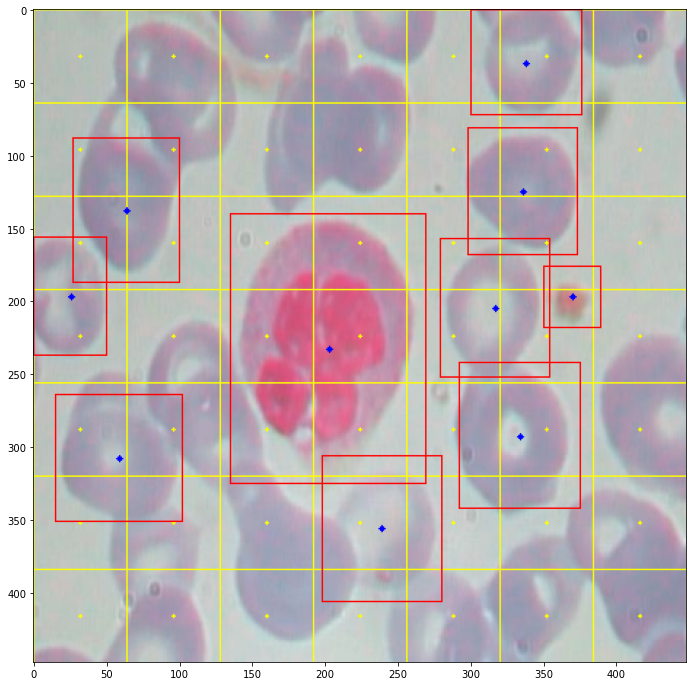

In [354]:
i = np.random.randint(len(images))
img = images[i].copy()
dat = data[i]

grid,ref = grid_gen(grid_stride=grid_stride)

ba,pa = encode_target(dat,grid.copy())

for cord,prob,(y,x) in zip(ba.reshape(-1,k,2),pa.reshape(-1,k,1),grid.reshape(-1,2)):
    img = cv2.circle(
                    img,
                    (int(x),int(y)),
                    1,
                    (255,255,0),
                    -1
                )
    img = cv2.rectangle(
                    img,
                    (x-(grid_stride//2),y-(grid_stride//2)),
                    (x+(grid_stride//2),y+(grid_stride//2)),
                    (255,255,0),
                    (1)
                )
    
    for (yy,xx),(p,) in zip(cord.reshape(-1,2),prob.reshape(-1,1)):
        if p:
            img = cv2.circle(
                        img,
                        (x+int(xx*grid_stride)-(grid_stride//2),y+int((yy*grid_stride))-(grid_stride//2)),
                        2,
                        (0,0,255),
                        -1
                    )
        
    

for j,b in enumerate(dat.boxes):
    img = cv2.rectangle(
                    img,
                    (int(b.xmin*IMG_SIZE),int(b.ymin*IMG_SIZE)),
                    (int(b.xmax*IMG_SIZE),int(b.ymax*IMG_SIZE)),
                    (255,0,0),
                    1
                )
    
    
plt.figure(figsize=(12,12))
plt.imshow(img)

In [355]:
y_prob = []
y_box = []

for d in data:
    bp,pp = encode_target(d,grid.copy())
    
    y_box.append(bp)
    y_prob.append(pp)
    
y_prob = np.array(y_prob)
y_box = np.array(y_box)

In [356]:
y_prob.shape,y_box.shape

((364, 7, 7, 5, 1), (364, 7, 7, 5, 2))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


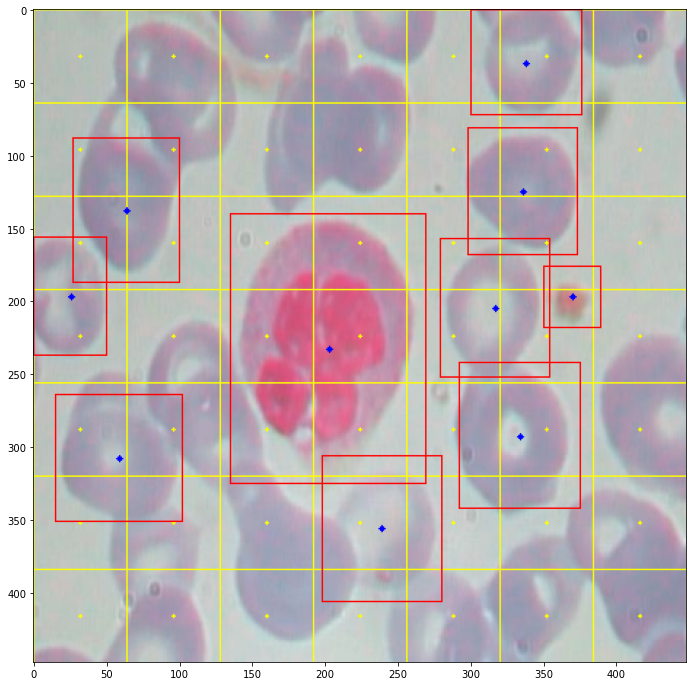

In [357]:
img = images[i].copy()
dat = data[i]
ba = y_box[i].copy()
pa = y_prob[i].copy()

for cord,prob,(y,x) in zip(ba.reshape(-1,k,2),pa.reshape(-1,k,1),grid.reshape(-1,2)):
    img = cv2.circle(
                    img,
                    (int(x),int(y)),
                    1,
                    (255,255,0),
                    -1
                )
    img = cv2.rectangle(
                    img,
                    (x-(grid_stride//2),y-(grid_stride//2)),
                    (x+(grid_stride//2),y+(grid_stride//2)),
                    (255,255,0),
                    (1)
                )
    
    for (yy,xx),(p,) in zip(cord.reshape(-1,2),prob.reshape(-1,1)):
        if p:
            img = cv2.circle(
                        img,
                        (x+int(xx*grid_stride)-(grid_stride//2),y+int((yy*grid_stride))-(grid_stride//2)),
                        2,
                        (0,0,255),
                        -1
                    )
        
    

for j,b in enumerate(dat.boxes):
    img = cv2.rectangle(
                    img,
                    (int(b.xmin*IMG_SIZE),int(b.ymin*IMG_SIZE)),
                    (int(b.xmax*IMG_SIZE),int(b.ymax*IMG_SIZE)),
                    (255,0,0),
                    1
                )
    
    
plt.figure(figsize=(12,12))
plt.imshow(img)

In [358]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler,Callback

In [359]:
_input = Input(shape=(448,448,3))


def block(name:str,filters:int,ksize:int,_input:Layer,pool=False):
    block_0 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"block_{name}_conv0")(_input)
    block_1 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"block_{name}_conv1")(block_0)
    block_2 = BatchNormalization(name=f"block_{name}_norm_0")(block_1)
    block_3 = Conv2D(filters,ksize,activation="relu",padding="same",name=f"block_{name}_conv2")(block_2)
    block_4 = Conv2D(filters,1,activation="relu",padding="same",name=f"block_{name}_conv3")(block_3)
    block_5 = BatchNormalization(name=f"block_{name}_norm_1")(block_4)
    
    block_out = concatenate([_input,block_5],name=f"block_{name}_conc")
    if pool:
        block_out = MaxPool2D(name=f"block_{name}_pool")(block_out)
    return block_out


_in = Conv2D(128,7,activation="relu",strides=2,padding="same",)(_input)
a  = block(name="a",filters=32,ksize=3,_input=_in,pool=True)
b  = block(name="b",filters=64,ksize=3,_input=a,pool=True)
c  = block(name="c",filters=128,ksize=3,_input=b,pool=True)
d  = block(name="d",filters=256,ksize=3,_input=c,pool=True)
e = Conv2D(2048,3,activation="relu",strides=2,padding="same")(d)

prob = Conv2D(5,1,padding="same")(e)
prob = BatchNormalization()(prob)
prob = Activation("sigmoid",name="prob")(prob)

box = Conv2D(10,1,padding="same")(e)
box = BatchNormalization()(box)
box = Activation("sigmoid",name="box")(box)

net = keras.Model(_input,[prob,box])

In [360]:
net.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 448, 448, 3) 0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 224, 224, 128 18944       input_16[0][0]                   
__________________________________________________________________________________________________
block_a_conv0 (Conv2D)          (None, 224, 224, 32) 36896       conv2d_60[0][0]                  
__________________________________________________________________________________________________
block_a_conv1 (Conv2D)          (None, 224, 224, 32) 9248        block_a_conv0[0][0]              
___________________________________________________________________________________________

In [361]:
%%time

a = net(images[0:1])

Wall time: 97.9 ms


In [362]:
binary_crossentropy = tf.keras.losses.BinaryCrossentropy()
l2_loss = tf.keras.losses.MeanSquaredError()
zeroes = tf.constant([[0.,0.]],dtype=tf.float32)

In [363]:
def box_loss(y_true,y_pred):
    b_pred = tf.reshape(y_pred,(-1,k*49,2))
    b_true = tf.reshape(y_true,(-1,k*49,2))
    mask = tf.greater(b_true , zeroes)
    mask = tf.reshape(tf.logical_or(tf.slice(mask,[0,0,0],[-1,-1,1]),tf.slice(mask,[0,0,1],[-1,-1,1])),(-1,k*25))
    
    return l2_loss(b_true[mask],b_pred[mask])

In [364]:
i = 0

_,y_pred  = net(images[i:i+3])
y_true  = y_box[i:i+3].copy().astype(np.float32)

In [365]:
y_pred.shape

TensorShape([3, 7, 7, 10])

In [366]:
y_true.shape

(3, 7, 7, 5, 2)

In [367]:
def box_loss(y_true,y_pred,*args,**kwargs):
    b_pred = tf.reshape(y_pred,(-1,k*g*g,2))
    b_true = tf.reshape(y_true,(-1,k*g*g,2))
    mask = tf.greater(b_true , zeroes)
    mask = tf.reshape(tf.logical_or(tf.slice(mask,[0,0,0],[-1,-1,1]),tf.slice(mask,[0,0,1],[-1,-1,1])),(-1,k*g*g))
    return l2_loss(b_true[mask],b_pred[mask])

In [374]:
def schedule(epoch):
    if epoch > 35:
        return .000001
    elif epoch > 20:
        return .00001
    else:
        return .0001

In [375]:
lrs = LearningRateScheduler(schedule=schedule,)
chk = ModelCheckpoint(filepath="./checkpoints/net1",save_weights_only=True,monitor='loss',)

In [376]:
opt = keras.optimizers.Adam()

In [377]:
net.compile(optimizer=opt,loss={"prob":binary_crossentropy,"box":box_loss})

In [378]:
net.load_weights("checkpoints/net1")

In [379]:
net.fit(images,(y_prob,y_box),batch_size=1,epochs=40,callbacks=[lrs,chk])

Train on 364 samples
Epoch 1/40
364/364 [==============================] - 61s 168ms/sample - loss: 0.0038 - prob_loss: 0.0028 - box_loss: 9.9739e-04
Epoch 2/40
364/364 [==============================] - 60s 164ms/sample - loss: 0.0032 - prob_loss: 0.0024 - box_loss: 7.2747e-04
Epoch 3/40
364/364 [==============================] - 60s 164ms/sample - loss: 0.0029 - prob_loss: 0.0023 - box_loss: 5.9634e-04
Epoch 4/40
364/364 [==============================] - 59s 163ms/sample - loss: 0.0027 - prob_loss: 0.0021 - box_loss: 5.0751e-04
Epoch 5/40
364/364 [==============================] - 60s 166ms/sample - loss: 0.0025 - prob_loss: 0.0021 - box_loss: 4.4034e-04
Epoch 6/40
364/364 [==============================] - 60s 164ms/sample - loss: 0.0024 - prob_loss: 0.0020 - box_loss: 3.8821e-04
Epoch 7/40
364/364 [==============================] - 61s 168ms/sample - loss: 0.0023 - prob_loss: 0.0019 - box_loss: 3.4406e-04
Epoch 8/40
364/364 [==============================] - 58s 158ms/sample - los

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


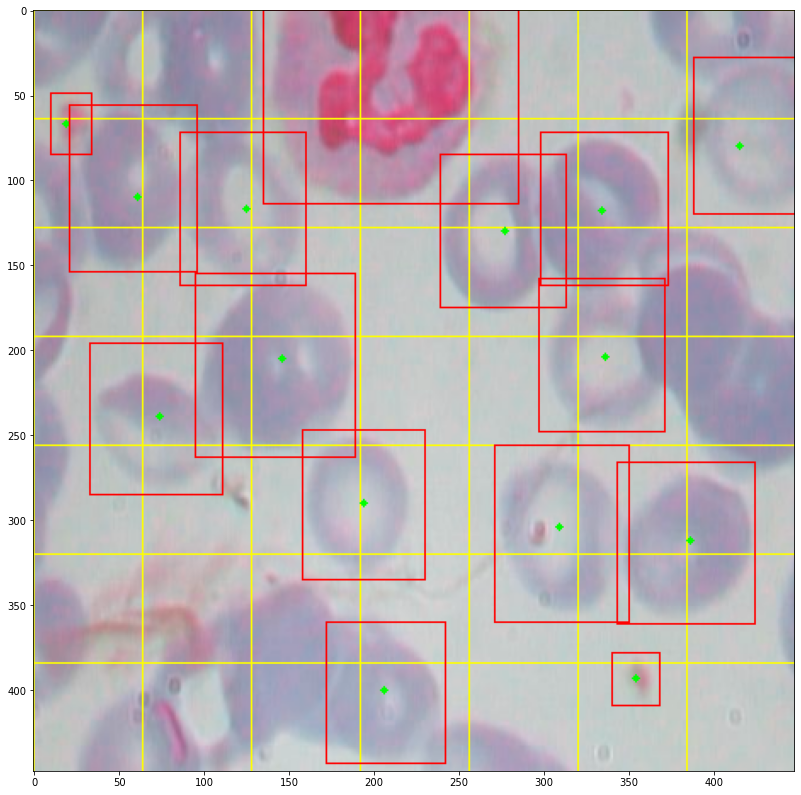

In [383]:
i = np.random.randint(len(images))

img = images[i].copy()
pa,ba = net.predict(img.reshape(1,IMG_SIZE,IMG_SIZE,3))
dat = data[i]

for (y,x),ps,bs in zip(grid.reshape(-1,2),pa.reshape(-1,k,1),ba.reshape(-1,k,2)):
    
    img = cv2.rectangle(
        img,
        (x-(grid_stride//2),y-(grid_stride//2)),
        (x+(grid_stride//2),y+(grid_stride//2)),
        (255,255,0),
        1
    )
    
    for (p,),(yy,xx) in zip(ps,bs):
        if p > .9:
            yy,xx = int(yy*64),int(xx*64)
            img = cv2.circle(img,(x-32+xx,y-32+yy),2,(0,255,0),-1)
            
            
for b in dat.boxes:
    img = cv2.rectangle(
            img,
            (int(b.xmin*IMG_SIZE),int(b.ymin*IMG_SIZE)),
            (int(b.xmax*IMG_SIZE),int(b.ymax*IMG_SIZE)),
            (255,0,0),
            1
        )
            
plt.figure(figsize=(14,14))
plt.imshow(img)